In [1]:
import pandas as pd 
import numpy as np
import re

# https://github.com/petrosDemetrakopoulos/RNN-Beatles-lyrics-generator
# https://github.com/starry91/Lyric-Generator#2-lyric-generator-based-on-word-level-rnn

In [2]:
import torch 
print(torch.cuda.is_available())
torch.cuda.current_device()

True


0

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
# ssh -i "ling380.pem" ec2-user@ec2-3-21-233-161.us-east-2.compute.amazonaws.com

In [5]:
# Reading in language CSV 
data = pd.read_csv("language-processed-data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["genre"].replace({"country": "Country", "soul": "Soul", "jazz":"Jazz", 
                            "folk":"Folk", "pop":"Pop", "metal":"Metal", "rb":"R&B", 
                            "rock":"Rock", "rap":"Rap"}, inplace=True)
print(data.groupby(['genre']).size())

genre
Country           20115
Electronic         7009
Folk               5777
Hip-Hop           23045
Indie              2971
Jazz              12247
Metal             29418
Not Available     17582
Other              3985
Pop               43211
R&B                7704
Rap               10105
Rock             110690
Soul               4069
dtype: int64


In [6]:
print(data.shape)
print(data.head())

(297928, 6)
            artist genre            title  \
0  beyonce-knowles   Pop        ego remix   
1  beyonce-knowles   Pop     then tell me   
2  beyonce-knowles   Pop          honesty   
3  beyonce-knowles   Pop  you are my rock   
4  beyonce-knowles   Pop    black culture   

                                              lyrics  word_num language  
0  Oh baby, how you doing?\nYou know I'm gonna cu...       NaN       en  
1  playin' everything so easy,\nit's like you see...       NaN       en  
2  If you search\nFor tenderness\nIt isn't hard t...       NaN       en  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...       NaN       en  
4  Party the people, the people the party it's po...       NaN       en  


## Prediction

- User inputs a song title, and how many words they want the song to be. 
- Network does, for example, 100 predictions, and in the training phrase we know what word we need to generate. 
- (genre, song title); have a marker that it's the end of the title 

# Word Level LSTM

In [7]:
stopChars = [',','(',')','.','-','[',']','"']
# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
#     text = text.replace('\n', ' ').replace('\t','')
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

# tokenization 
def corpusToList(corpus):
    corpusList = [w for w in corpus.split(' ')] 
    corpusList = [i for i in corpusList if i] #removing empty strings from list
    return corpusList

In [8]:
def sample_data(genre, sample_size):
    data1 = data
    data1 = data1[data1['genre'] == genre].sample(sample_size)
    data1['lyrics'] = data1['lyrics'].astype(str)
    data1['lyrics']= data1['lyrics'].apply(preprocessText)
    return data1

In [9]:
def tokenize_data(data):
    newlines = re.sub("\n", " \n ", data['lyrics'].str.cat(sep='\n').lower())
    exclamation = re.sub("!", " ! ", newlines)
    question = re.sub("!", " ! ", exclamation)
    DP_text = re.findall(r'\S+|\n', question)
    print('corpus length:', len(DP_text))
    return(DP_text)

In [10]:
# Create a dictionary of characters, see the index of characters.
def dictionary_maker(words):
    char_to_int = dict((c, i) for i, c in enumerate(words))
    int_to_char = dict((i, c) for i, c in enumerate(words))
    return(char_to_int, int_to_char)

In [11]:
def make_sentences_and_next_chars(seq_length, DP_text, step):
    sentences = []
    next_chars = []

    # Create Target and sentences window
    for i in range(0, len(DP_text) - seq_length, step):
        # range from current index to sequence length charaters
        sentences.append(DP_text[i: i + seq_length])  
        next_chars.append(DP_text[i + seq_length]) # the next character
    
    sentences = np.array(sentences)
    next_chars = np.array(next_chars)
    return(sentences, next_chars)

In [12]:
rap_data = sample_data('Hip-Hop', 2000)
print(rap_data.shape)
print(rap_data.genre.unique())
#pop_data = sample_data('pop', 2000)
#country_data = sample_data('country', 2000)

(2000, 6)
['Hip-Hop']


In [13]:
DP_rap = tokenize_data(rap_data)
#DP_pop = tokenize_data(pop_data)
#DP_country = tokenize_data(country_data)

corpus length: 1130450


In [14]:
# Counting characters appeared in all lyrics
rap_words = sorted(list(set(DP_rap)))
#pop_words = sorted(list(set(DP_pop)))
#country_words = sorted(list(set(DP_country)))

In [15]:
rap_char_to_int, rap_int_to_char = dictionary_maker(rap_words)
#pop_char_to_int, pop_int_to_char = dictionary_maker(pop_words)
#country_char_to_int, country_int_to_char = dictionary_maker(country_words)

In [16]:
rap_sentences, rap_next_chars = make_sentences_and_next_chars(16, DP_rap, 1)
#pop_sentences, pop_next_chars = make_sentences_and_next_chars(16, DP_pop, 1)
#country_sentences, country_next_chars = make_sentences_and_next_chars(16, DP_country, 1)

In [17]:
# transferring the character to index 
def getdata(sentences, next_chars, seq_length, char_to_int):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [19]:
class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [20]:
def train_model(sentences, next_chars, epoch_count, words, seq_length, char_to_int):
    train_x, train_y = getdata(sentences, next_chars, seq_length, char_to_int)
    
    X_train_tensor = torch.tensor(train_x, dtype=torch.long).to(device)
    Y_train_tensor = torch.tensor(train_y, dtype=torch.long).to(device)
    
    from torch.utils.data import Dataset, DataLoader
    train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train, batch_size = 128)
    
    model = Simple_LSTM(len(words),256,256).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
    
    import time # Add time counter
    avg_losses_f = []
    n_epochs = epoch_count

    for epoch in range(n_epochs):
        print("Epoch: ", epoch)
        start_time = time.time()
        model.train()
        loss_fn = torch.nn.CrossEntropyLoss()
        avg_loss = 0.
        for i, (x_batch, y_batch) in enumerate(train_loader):
        
            y_pred = model(x_batch)
        
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
        
            optimizer.step()
            avg_loss+= loss.item()/len(train_loader)
        
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, elapsed_time))
    
        avg_losses_f.append(avg_loss)    
    
    print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))
    
    import matplotlib.pyplot as plt

    plt.plot(avg_losses_f)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.show()
    
    
    return(model)

Epoch:  0
Epoch 1/20 	 loss=6.0280 	 time=1209.32s
Epoch:  1
Epoch 2/20 	 loss=5.4314 	 time=1208.70s
Epoch:  2
Epoch 3/20 	 loss=5.1225 	 time=1208.24s
Epoch:  3
Epoch 4/20 	 loss=4.8735 	 time=1208.16s
Epoch:  4
Epoch 5/20 	 loss=4.6843 	 time=1160.67s
Epoch:  5
Epoch 6/20 	 loss=4.5404 	 time=743.46s
Epoch:  6
Epoch 7/20 	 loss=4.4251 	 time=383.95s
Epoch:  7
Epoch 8/20 	 loss=4.3278 	 time=340.14s
Epoch:  8
Epoch 9/20 	 loss=4.2506 	 time=340.08s
Epoch:  9
Epoch 10/20 	 loss=4.1854 	 time=339.63s
Epoch:  10
Epoch 11/20 	 loss=4.1288 	 time=339.60s
Epoch:  11
Epoch 12/20 	 loss=4.0793 	 time=339.64s
Epoch:  12
Epoch 13/20 	 loss=4.0393 	 time=339.59s
Epoch:  13
Epoch 14/20 	 loss=4.0013 	 time=340.28s
Epoch:  14
Epoch 15/20 	 loss=3.9677 	 time=339.43s
Epoch:  15
Epoch 16/20 	 loss=3.9378 	 time=337.48s
Epoch:  16
Epoch 17/20 	 loss=3.9090 	 time=337.35s
Epoch:  17
Epoch 18/20 	 loss=3.8847 	 time=337.38s
Epoch:  18
Epoch 19/20 	 loss=3.8616 	 time=337.86s
Epoch:  19
Epoch 20/20 	 l

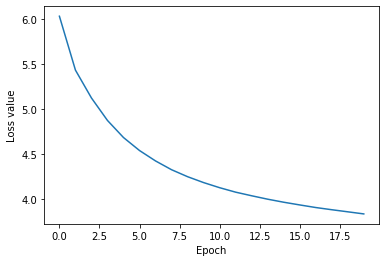

hiphop done


In [21]:
hiphop_model = train_model(rap_sentences, rap_next_chars, 20, rap_words, 16, rap_char_to_int)
torch.save(hiphop_model.state_dict(), 'hiphop_checkpoint.pth')
print("hiphop done")

In [22]:
#pop_model = train_model(pop_sentences, pop_next_chars, 5, pop_words, 16, pop_char_to_int)
# print("pop done")

In [23]:
#country_model = train_model(country_sentences, country_next_chars, 5, country_words, 16, country_char_to_int)
# print("country done")

In [24]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [25]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
seq_length = 16
char_to_int = rap_char_to_int
int_to_char = rap_int_to_char
sentence = ["on", "god", "i", "love", "the", "blow", "\n", "on", "god", "i",
           "love", "the", "pussy", "\n", "but", "more"]
variance = .5
generated = []
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x).to(device))
    pred = hiphop_model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
    
print(" ".join(original + generated))

on god i love the blow 
 on god i love the pussy 
 but more than a tattoo in the range rove 
 same o'clock 
 all these women are droppin' 
 and if you don't go out of jail 
 and your life was the kingdom 
 i feel the effects of a chicken 
 i never knew that i was a long time 
 so i can see a little bit of liquor 
 i got a tear for the fridge 
 my momma are in the english 
 that's where the fuck is maggie 
 the condoms be yelling 
 iriscience 
 i don't know i'm a man 
 i be that one in the club 
 i'm wildin' with a treasure or a good mistake 
 niggas ain't got no money but i'm a thug money 
 i ain't got that money money hungry 
 repeat 
 busta rhymes 
 50 cent 
 aiyyo 
 cypress hill 
 a studio 
 flipmode 
 cappadonna 
 rza 
 rza 
 i'm 5'5 
 bizzy bone 
 assassins sharp 
 slaying 
 flipmode 
 scary 
 you know how we do it 
 common: 
 the nigga recline we blow up high? 
 we gotta be stylin' in the city 
 we don't play that we gotta get it all we don't get it 
 we ain't gotta go to the gam